In [50]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [51]:
!which python

/Users/ziru/miniforge3/envs/gesture_input/bin/python


### Preprocessing

In [52]:
# load data
data_folder = Path("./data/")

data = {}

for gesture_file in data_folder.glob("*.csv"):
    gesture_name = gesture_file.stem
    data[gesture_name] = pd.read_csv(gesture_file)

# gesture classes
print(data.keys())

dict_keys(['c', 'u', 'b', 'f', 'd', 'i', 'o', 'x', 'y', 'n', 'l'])


In [53]:
# look at data from one gesture
data["u"]

,L-AccX,L-AccY,L-AccZ,L-GyrX,L-GyrY,L-GyrZ,R-AccX,R-AccY,R-AccZ,R-GyrX,R-GyrY,R-GyrZ,timestamp
0,0.00000,-0.18000,0.09750,0.003800,0.000992,0.018310,-0.00125,0.08750,0.09000,0.000472,-0.000245,0.000077,1.742002e+09
1,0.02000,0.00875,0.01875,0.119523,-0.073075,0.035980,-0.00000,0.08750,0.09625,0.000702,-0.002227,0.000870,1.742002e+09
2,-0.04625,-0.12250,0.13375,0.028977,-0.028535,-0.052643,-0.00500,0.08500,0.08750,0.002488,-0.006195,-0.000015,1.742002e+09
3,-0.15750,-0.27750,-0.01750,0.046172,0.028550,-0.045135,-0.01125,0.08000,0.08125,0.001572,-0.001692,0.002960,1.742002e+09
4,-0.13625,-0.19625,-0.04875,-0.012483,0.014495,0.062058,-0.01375,0.08375,0.09375,-0.001405,0.002547,0.001847,1.742002e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,0.01500,-0.10375,0.02875,-0.014220,0.026337,0.038040,0.00250,0.08875,0.08875,-0.001175,0.001175,0.000443,1.742002e+09
136,0.04250,-0.07125,0.03125,-0.038985,0.042435,0.003495,0.00000,0.09250,0.08500,-0.001008,0.001692,0.000915,1.742002e+09
137,0.05375,-0.07250,0.04000,-0.078370,0.021880,-0.022170,0.00250,0.09250,0.08625,-0.001038,0.002120,0.001755,1.742002e+09
138,0.03375,-0.07500,0.07875,-0.003845,-0.004425,-0.011718,0.00125,0.09375,0.08750,0.000488,0.001298,0.002425,1.742002e+09


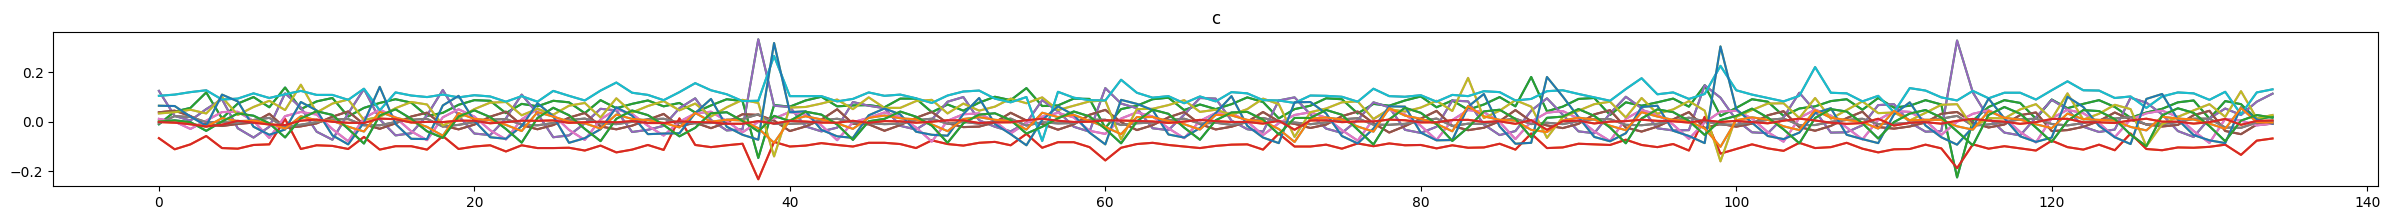

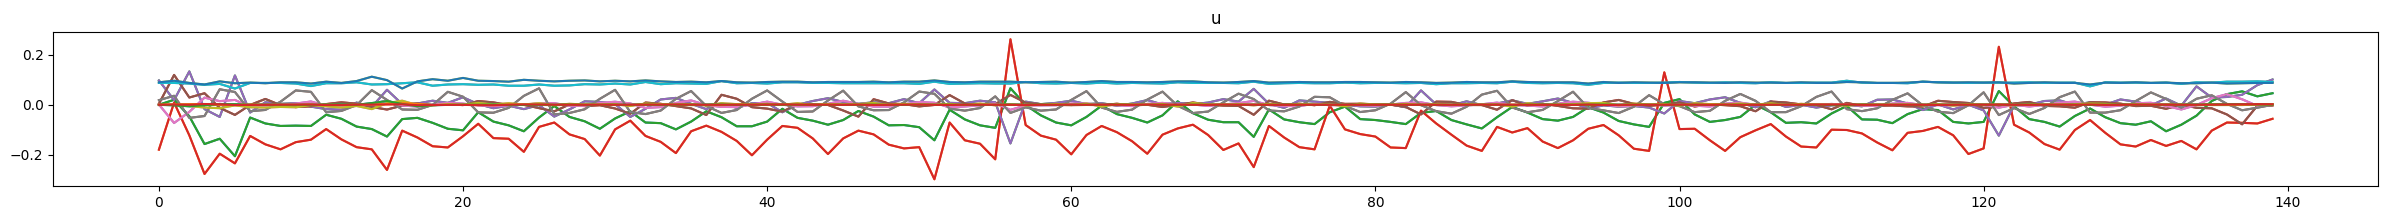

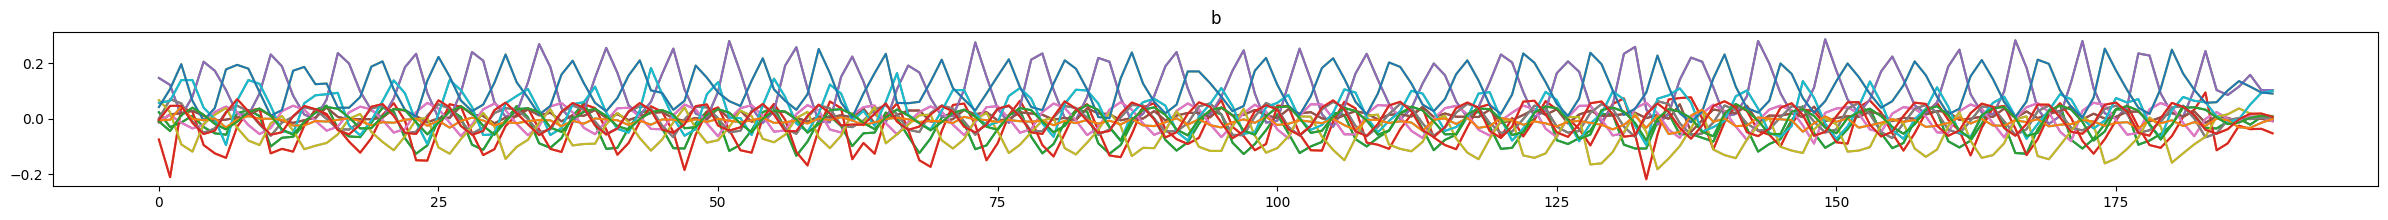

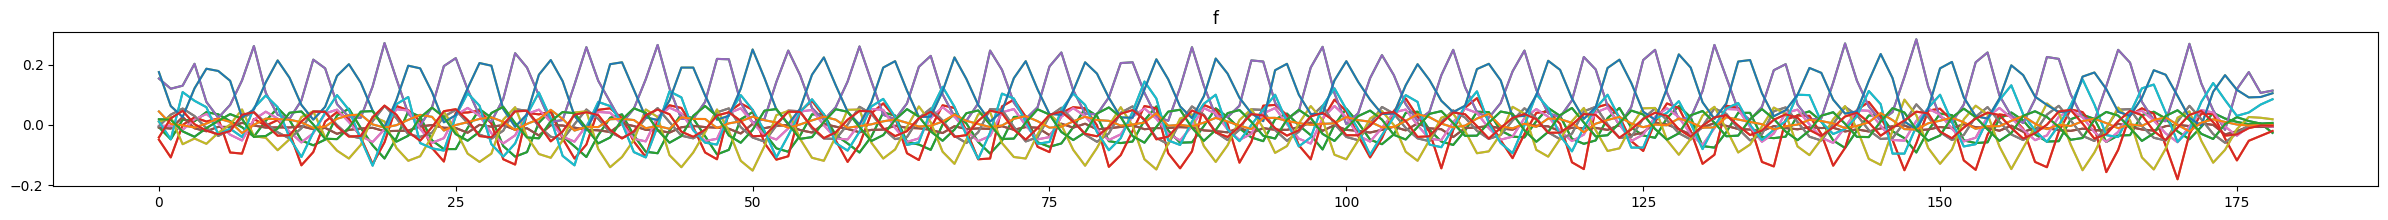

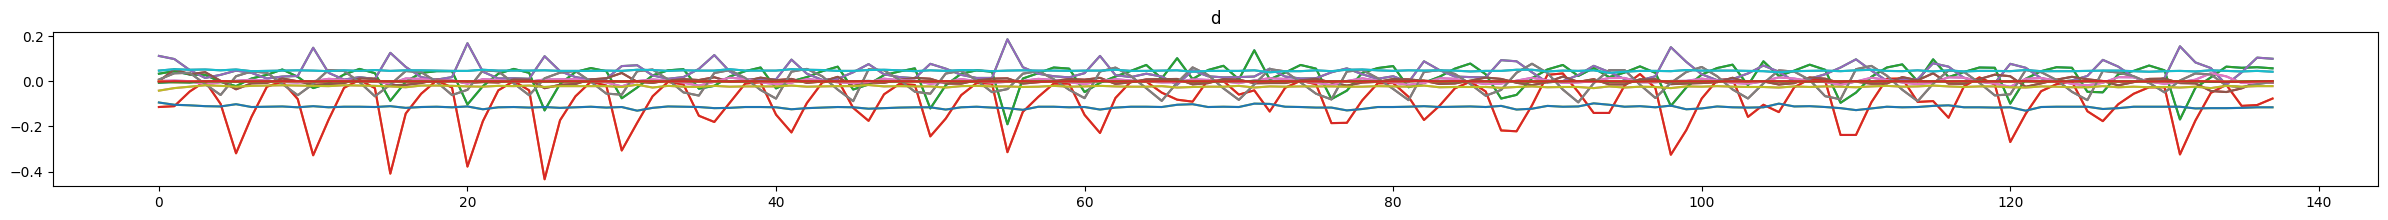

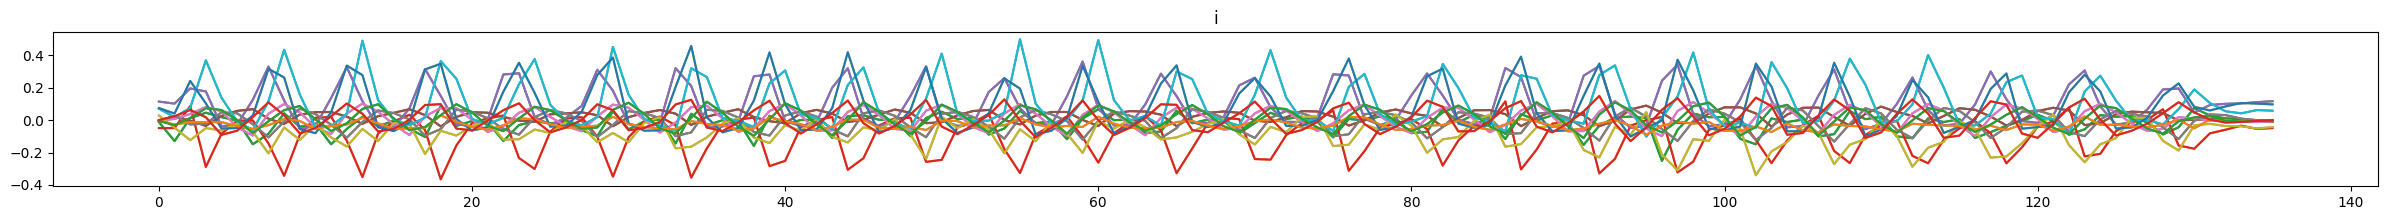

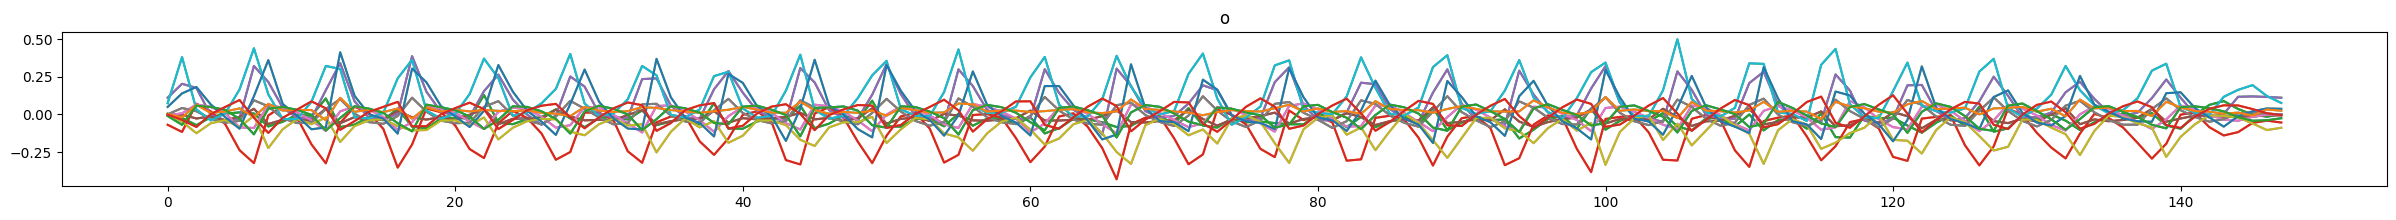

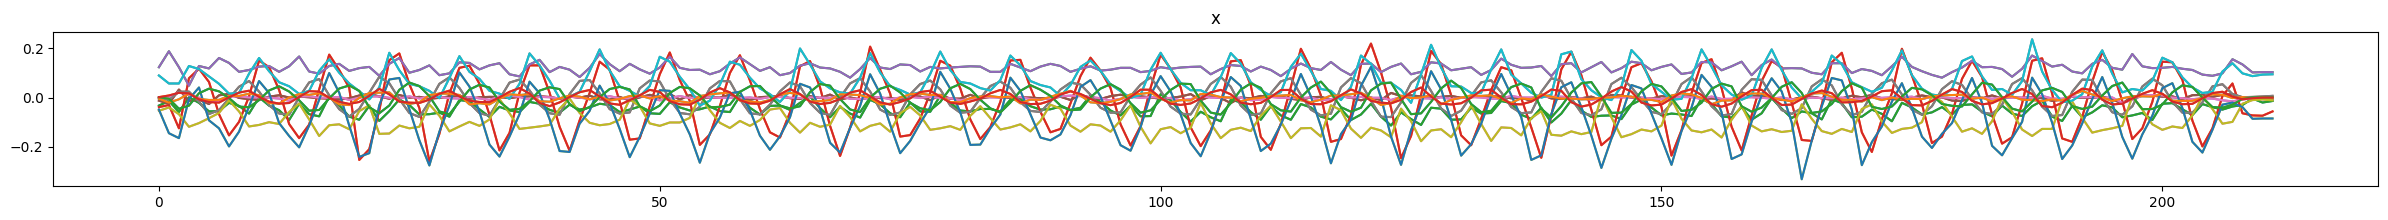

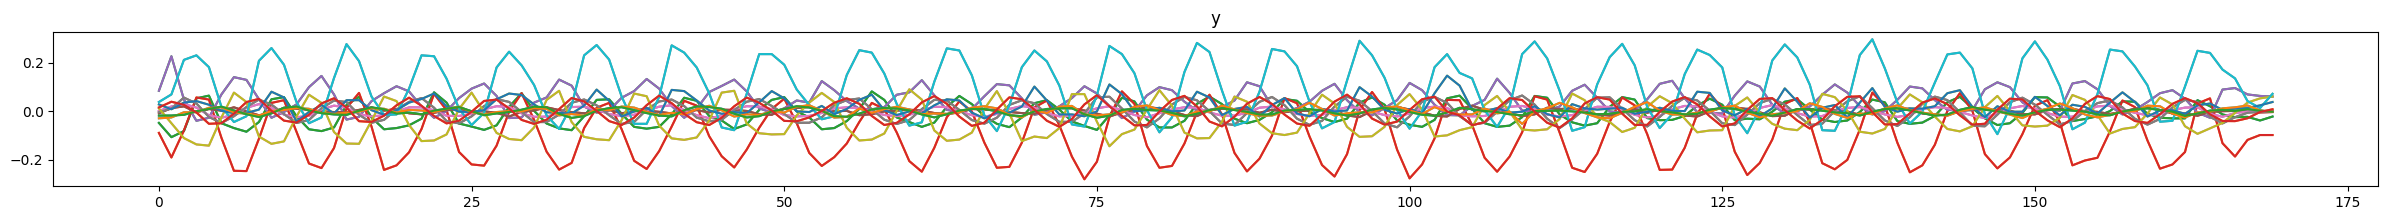

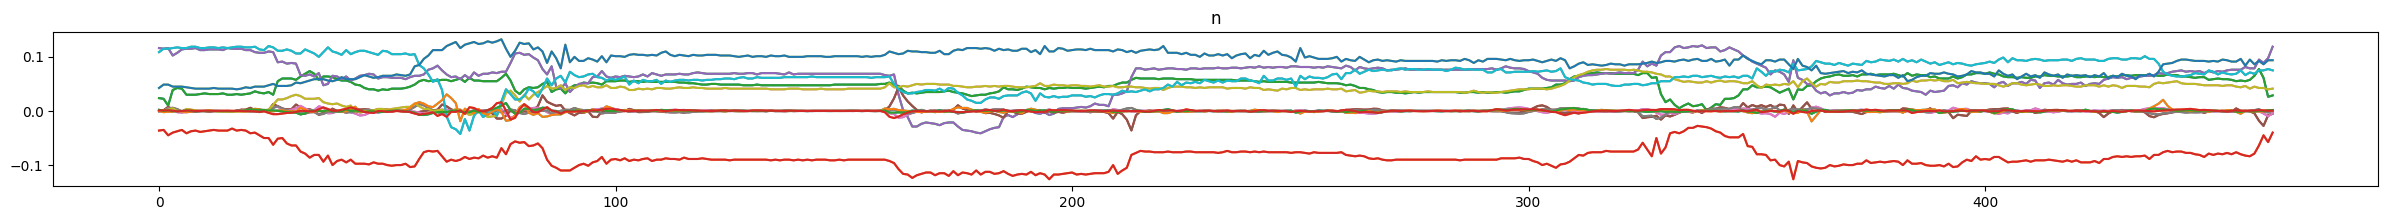

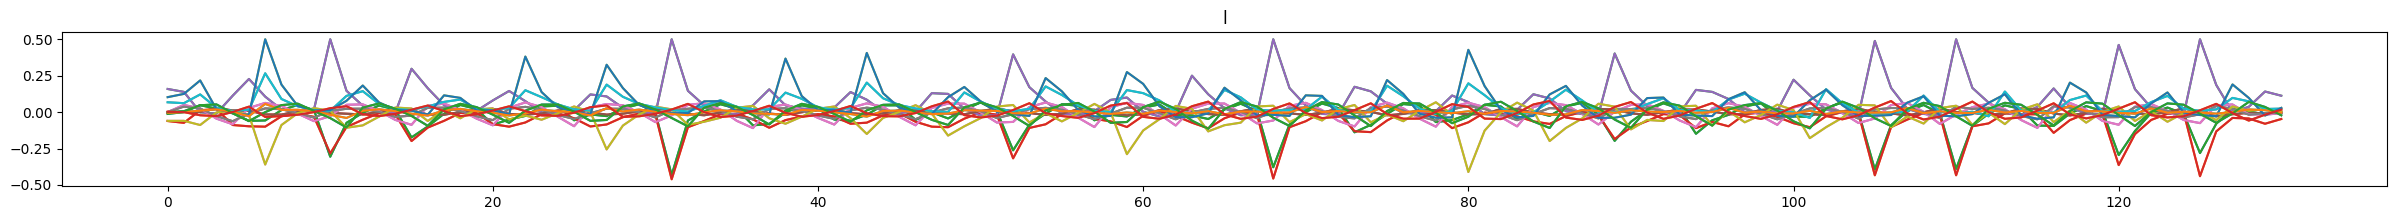

In [59]:
# visualize data from all gestures
for gesture_name, df in data.items():
    plt.figure(figsize=(30, 2))
    plt.title(gesture_name)
    plt.plot(df.values[:, :-1])
    plt.plot(df.values[:, :-1])
    plt.show()




### Training

1. 输入层
`Input(shape=(6 * window_size,))`

- 输入形状: (6 * window_size,)，例如 (300,)（假设 window_size=50，6 个 IMU 特征）。

- 作用: 接收展平后的滑动窗口数据（每个窗口包含 50 个时间步 × 6 个传感器维度 = 300 个特征）。

2. 全连接隐藏层
`Dense(64, activation='relu')`

- 神经元数量: 64

- 激活函数: ReLU（修正线性单元），引入非线性，帮助模型学习复杂模式。

- 参数数量: (300 + 1) * 64 = 19,264（300 输入特征，64 个神经元，每个神经元有 1 个偏置项）。

3. 输出层
`Dense(len(data.keys()), activation='softmax')`

- 神经元数量: 等于手势类别数（例如 data.keys() 返回 ['wave', 'circle', 'swipe']，则神经元数为 3）。

- 激活函数: Softmax，将输出转换为概率分布（所有类别的概率之和为 1）。

- 参数数量: (64 + 1) * num_classes（例如 3 类时有 (64+1)*3=195 个参数）。

1. 优化器 (Optimizer)  优化器 (Optimizer)
Adam(learning_rate=3e-4):

自适应学习率的优化算法，结合了动量（Momentum）和 RMSProp 的优点。

learning_rate=3e-4 是初始学习率，较小的值适合精细调整权重。

2. 损失函数 (Loss)
SparseCategoricalCrossentropy():

适用于多分类任务，且标签为整数形式（例如 0, 1, 2）。

如果是 one-hot 编码标签，应使用 CategoricalCrossentropy。

3. 评估指标 (Metrics)
SparseCategoricalAccuracy(name='accuracy'):

计算分类准确率，正确预测的样本比例。

同样适用于整数标签。

模型改进思路
调整网络结构:

增加更多隐藏层（如取消注释的 Dense(64, activation='relu')）。

添加 Dropout 层防止过拟合：

python
keras.layers.Dropout(0.5)
优化超参数:

调整学习率（如 1e-3 或 1e-4）。

使用学习率调度（如 ReduceLROnPlateau）。

数据增强:

对 IMU 数据进行随机扰动（如添加噪声、时间偏移）以增强鲁棒性。

In [61]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import keras

# 准备数据
window_size = 50
X = []
y = []
for gesture_name, df in data.items():
    # df.values[:, :-1] 假设前 n-1 列是特征
    df_values = df.values[:, :-1]  
    for i in range(0, len(df) - window_size):
        X.append(df_values[i:i+window_size])
        y.append(gesture_name)  # 这里是字符串

X = np.array(X)  # => (样本数, 50, 6)
y = np.array(y)  # => (样本数, )

print("X.shape =", X.shape)  # (N, 50, 6)
print("y.shape =", y.shape)  # (N, )

# 把字符串标签转成整数
encoder = LabelEncoder()
y_int = encoder.fit_transform(y)  # 0 ~ (num_classes-1)

# 划分训练/测试集
X_train, X_test, y_train, y_test = train_test_split(X, y_int, test_size=0.2, random_state=42)
print("X_train.shape =", X_train.shape, "y_train.shape =", y_train.shape)
print("X_test.shape =", X_test.shape, "y_test.shape =", y_test.shape)

# 定义模型
model = keras.Sequential([
    keras.layers.Input(shape=(window_size, 12)),  # (50, 6)
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(len(encoder.classes_), activation='softmax')  # 类别数 = labelEncoder 的 classes_ 数量
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    loss=keras.losses.SparseCategoricalCrossentropy(), 
    metrics=[keras.metrics.SparseCategoricalAccuracy(name='accuracy')]
)

# 训练
batch_size = 32
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath="./checkpoints/model_at_epoch_{epoch}.keras"),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=2),
]

history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.15,
    callbacks=callbacks,
)

# 测试集评估
score = model.evaluate(X_test, y_test, verbose=0)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])


X.shape = (1493, 50, 12)
y.shape = (1493,)
X_train.shape = (1194, 50, 12) y_train.shape = (1194,)
X_test.shape = (299, 50, 12) y_test.shape = (299,)
Epoch 1/10


2025-03-15 18:41:10.188005: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.2798 - loss: 2.3196 - val_accuracy: 0.5833 - val_loss: 2.0818
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5108 - loss: 2.0699 - val_accuracy: 0.6722 - val_loss: 1.8391
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5508 - loss: 1.8746 - val_accuracy: 0.7167 - val_loss: 1.6007
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6566 - loss: 1.6182 - val_accuracy: 0.7667 - val_loss: 1.3924
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7102 - loss: 1.4489 - val_accuracy: 0.8000 - val_loss: 1.2163
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7444 - loss: 1.2878 - val_accuracy: 0.8278 - val_loss: 1.0655
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7962 - loss: 1.1433 - val_accuracy: 0.8611 - val_loss: 0.9361
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8479 - loss: 0.9820 - val_accuracy: 0.9111 - val_loss: 0.

👉 callbacks 是训练过程中的“自动助手”，可以自动执行任务，比如保存模型、提前停止训练、调整学习率等。
👉 ModelCheckpoint 可以在每个 epoch 结束后保存模型，防止意外丢失训练进度。
👉 EarlyStopping 监控 val_loss，如果 2 轮不下降就停止训练，避免过拟合。

### Evaluation

In [62]:
print(f"Test loss: {score[0]:.4f}", f"Test accuracy: {score[1]:.4f}")

Test loss: 0.7635 Test accuracy: 0.8796


In [63]:
'_'.join(sorted(data.keys()))

'b_c_d_f_i_l_n_o_u_x_y'

### Saving

In [64]:
# save the model
import pickle
import time

# make the model name based on the gesture names
run_timestamp = str(time.time()).replace(".", "-")
model_name = '_'.join(sorted(data.keys())) + "__" + run_timestamp

# make a model directory
model_dir = Path('./models')
model_dir.mkdir(parents=True, exist_ok=True)

with open(model_dir / f'{model_name}.keras', 'wb') as f:
    pickle.dump(model, f)
with open(model_dir / f'label_encoder_{model_name}.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

In [65]:
model_name

'b_c_d_f_i_l_n_o_u_x_y__1742078486-1205251'

In [66]:
model.predict(X_test[[0]])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


array([[0.02210807, 0.10759457, 0.05633892, 0.02653807, 0.08320913,
        0.06714126, 0.07160439, 0.1267233 , 0.11785834, 0.03026008,
        0.29062393]], dtype=float32)

In [ ]:
X_test.shape

(819, 300)